In [1]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import IPython
import gc
import torch.nn.functional as F
import torchaudio.transforms as tt
import matplotlib
import matplotlib.pyplot as plt
import wandb
import random
import torch.optim as optim
import torchaudio.transforms as T

from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from typing import Dict  
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchaudio.sox_effects import apply_effects_tensor
from typing import Optional

%matplotlib inline

In [2]:
# Antes de los experimentos
os.environ['WANDB_REPOSITORY'] = "TP3_TD6"
os.environ['WANDB_BRANCH'] = "main"

wandb.login(key = os.environ["WANDB_API_KEY"])


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


wandb: Currently logged in as: luquishh (luquishh-universidad-torcuato-di-tella). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lucamazzarello_/.netrc


True

In [3]:
# Definir el sample rate
samplerate = 22050

### Clases

In [4]:
# Normalización de audio
class NormalizeAudio(nn.Module):
    def __init__(self, mean=0.0, std=1.0):
        super(NormalizeAudio, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, waveform):
        return (waveform - self.mean) / self.std

# Transformación de TimeStretch en la forma de onda usando SoX
class TimeStretchWaveform(nn.Module):
    def __init__(self, rate: float = 1.2):
        super(TimeStretchWaveform, self).__init__()
        self.rate = rate

    def forward(self, waveform: torch.Tensor, sample_rate: int = samplerate) -> torch.Tensor:
        effects = [
            ['tempo', f'{self.rate}']
        ]
        # Aplicar efectos de SoX
        waveform, _ = apply_effects_tensor(waveform, sample_rate, effects)
        return waveform

# Transformación de PitchShift en la forma de onda usando SoX
class PitchShiftWaveform(nn.Module):
    def __init__(self, n_steps: int = 2):
        super(PitchShiftWaveform, self).__init__()
        self.n_steps = n_steps

    def forward(self, waveform: torch.Tensor, sample_rate: int = samplerate) -> torch.Tensor:
        effects = [
            ['pitch', f'{self.n_steps * 100}'],  # Cada step corresponde a 100 cents
            ['rate', f'{sample_rate}']  # Mantener el sample rate original
        ]
        # Aplicar efectos de SoX
        waveform, _ = apply_effects_tensor(waveform, sample_rate, effects)
        return waveform

# Opcional: Resamplear si es necesario
class ResampleWaveform(nn.Module):
    def __init__(self, orig_freq: int, new_freq: int):
        super(ResampleWaveform, self).__init__()
        self.resample = torchaudio.transforms.Resample(orig_freq=orig_freq, new_freq=new_freq)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return self.resample(waveform)

class AddNoise(nn.Module):
    def __init__(self, noise_level=0.005):
        super(AddNoise, self).__init__()
        self.noise_level = noise_level

    def forward(self, spectrogram: torch.Tensor) -> torch.Tensor:
        noise = torch.randn_like(spectrogram) * self.noise_level
        return spectrogram + noise

# Dataset
class MusicDataset(Dataset):
    def __init__(self, root='./genres_5sec', transform=None):
        super().__init__()
        self.root = root
        self.files = []
        self.classes = self.get_classes(self.root)
        for c in self.classes:
            class_dir = os.path.join(root, c)
            for fname in os.listdir(class_dir):
                if fname.endswith('.wav'):
                    self.files.append((c, fname))
        # Ordenar las clases para tener índices consistentes
        self.classes = sorted(self.classes)
        self.transform = transform 
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        genre, fname = self.files[idx]
        fpath = os.path.join(self.root, genre, fname)
        class_idx = self.classes.index(genre)
        waveform, sample_rate = torchaudio.load(fpath)
        
        # Convertir a mono si tiene múltiples canales
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Resamplear si es necesario
        if sample_rate != samplerate:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=samplerate)
            waveform = resample_transform(waveform)
            sample_rate = samplerate
        
        if self.transform:
            waveform = self.transform(waveform)
        
        # Asegurar que la forma de onda tenga una longitud fija (ejemplo: 5 segundos)
        fixed_length = samplerate * 5  # 5 segundos
        if waveform.size(1) > fixed_length:
            waveform = waveform[:, :fixed_length]
        elif waveform.size(1) < fixed_length:
            padding = fixed_length - waveform.size(1)
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        
        return waveform, class_idx
        
    def get_classes(self, root):
        list_files = os.listdir(root)
        classes = []
        for file in list_files:
            name = os.path.join(root, file)
            if os.path.isdir(name):
                classes.append(file)
        return classes

# Modelos
class MLP(nn.Module):
    def __init__(self, n_input, nodes=128, n_output=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_input, nodes)
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, n_output)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

class MLP2(nn.Module):
    def __init__(self, n_input, nodes=128, n_output=10, hidden_layers=3):
        super(MLP2, self).__init__()

        self.dense_layers = nn.ModuleList()
        in_features = n_input
        
        for i in range(hidden_layers):
            layer = nn.Sequential(
                nn.Linear(in_features, nodes),
                nn.ReLU(),
            )
            self.dense_layers.append(layer)
            in_features = nodes
            
        # Output layer
        self.output = nn.Linear(nodes, n_output)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        
        # Pass through all dense layers
        for layer in self.dense_layers:
            x = layer(x)
            
        x = self.output(x)
        return F.log_softmax(x, dim=1)
    
class CEL(nn.Module):
    def __init__(self, n_input, nodes=128, n_output=10, hidden_layers=3, dropout_prob=0.3, dense_layers=2):
        super(CEL, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = 1
        out_channels = nodes
        
        for _ in range(hidden_layers):
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout2d(dropout_prob)
            )
            self.conv_layers.append(conv_block)
            in_channels = out_channels
            out_channels = out_channels * 2
        
        # Calculate the size after convolutions
        self.flatten_size = nodes * (n_input // (2**hidden_layers)) * (n_input // (2**hidden_layers))
        
        # Dense layers
        self.dense_layers = nn.ModuleList()
        in_features = self.flatten_size
        out_features = nodes
        
        for i in range(dense_layers):
            if i == dense_layers - 1:
                out_features = n_output
            
            dense_block = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.ReLU() if i < dense_layers - 1 else nn.Identity(),
                nn.Dropout(dropout_prob) if i < dense_layers - 1 else nn.Identity()
            )
            self.dense_layers.append(dense_block)
            in_features = out_features

    def forward(self, x):
        # Apply convolutional layers
        for conv_block in self.conv_layers:
            x = conv_block(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Apply dense layers
        for dense_block in self.dense_layers:
            x = dense_block(x)
            
        return F.log_softmax(x, dim=1)

### Funciones

In [5]:
# Parseo de géneros
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

# Obtener clases
def classes(root = './genres_5sec'):
    list_files=os.listdir(root)
    classes=[]
    for file in list_files:
        name='{}/{}'.format(root,file)
        if os.path.isdir(name):
            classes.append(file)
    return classes

# Plotear waveforms
def plot_waveforms(dataset, num_samples=5, figsize=(15, 10)):
    """
    Plotea múltiples waveforms con sus etiquetas correspondientes.
    
    Args:
        dataset: Dataset que contiene los audios y etiquetas
        num_samples: Número de waveforms a mostrar
        figsize: Tamaño de la figura (ancho, alto)
    """
    
    fig, axes = plt.subplots(num_samples, 1, figsize=figsize)
    fig.suptitle('Waveforms de diferentes géneros musicales', fontsize=16)
    
    # Asegurarse de que axes sea siempre una lista
    if num_samples == 1:
        axes = [axes]
    
    # Obtener índices aleatorios sin repetición
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx, ax in zip(indices, axes):
        waveform, label = dataset[idx]
        genre = dataset.classes[label]
        
        # Plotear la waveform
        ax.plot(waveform.t().numpy()[0], linewidth=1)
        ax.set_title(f'Género: {genre}')
        ax.set_xlabel('Tiempo (muestras)')
        ax.set_ylabel('Amplitud')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Para comparar waveforms del mismo género
def plot_genre_waveforms(dataset, genre_name, num_samples=3, figsize=(15, 8)):
    """
    Plotea múltiples waveforms del mismo género.
    
    Args:
        dataset: Dataset que contiene los audios y etiquetas
        genre_name: Nombre del género a visualizar
        num_samples: Número de waveforms a mostrar
        figsize: Tamaño de la figura (ancho, alto)
    """
    
    genre_idx = dataset.classes.index(genre_name)
    genre_samples = [(i, wave, label) for i, (wave, label) in enumerate(dataset) if label == genre_idx]
    
    if len(genre_samples) < num_samples:
        num_samples = len(genre_samples)
    
    selected_samples = random.sample(genre_samples, num_samples)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=figsize)
    fig.suptitle(f'Waveforms del género: {genre_name}', fontsize=16)
    
    if num_samples == 1:
        axes = [axes]
    
    for i, (idx, waveform, _) in enumerate(selected_samples):
        axes[i].plot(waveform.t().numpy()[0], linewidth=1)
        axes[i].set_title(f'Muestra {idx}')
        axes[i].set_xlabel('Tiempo (muestras)')
        axes[i].set_ylabel('Amplitud')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
# Stratify split
def stratify_split(dataset: Dataset, classes: list[int], transforms: Dict[str, nn.Module] = {'train': None, 'val': None, 'test': None}) -> tuple[Subset, Subset, Subset]:
    
    train_indices = []
    val_indices = []
    test_indices = []

    NUM_CLASSES = len(classes)
    total_samples = len(dataset)
    
    # Calcular el número de muestras para cada conjunto
    train_samples = int(total_samples * 0.8)
    val_samples = int(total_samples * 0.1)
    test_samples = total_samples - train_samples - val_samples  # Resto para test

    train_samples_per_class = train_samples // NUM_CLASSES
    val_samples_per_class = val_samples // NUM_CLASSES
    test_samples_per_class = test_samples // NUM_CLASSES

    train_target_counter = collections.Counter()
    val_target_counter = collections.Counter()
    test_target_counter = collections.Counter()

    for idx, data in enumerate(dataset):
        target = data[1]
        if train_target_counter[target] < train_samples_per_class:
            train_indices.append(idx)
            train_target_counter[target] += 1
        elif val_target_counter[target] < val_samples_per_class:
            val_target_counter[target] += 1
            val_indices.append(idx)
        elif test_target_counter[target] < test_samples_per_class:
            test_target_counter[target] += 1
            test_indices.append(idx)

    train_dataset = Subset(
        MusicDataset(root=dataset.root, transform=transforms['train']), 
        train_indices
    )
    
    val_dataset = Subset(
        MusicDataset(root=dataset.root, transform=transforms['val']), 
        val_indices
    )

    test_dataset = Subset(
        MusicDataset(root=dataset.root, transform=transforms['test']), 
        test_indices
    )

    return train_dataset, val_dataset, test_dataset

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model_name, num_epochs, device, hyperparameter_configs, dataset, train_dataset, val_dataset, n_input, by):

    # Inicializar variables para seguimiento de mejores y peores experimentos
    best_valid_loss = float('inf')

    # Definir función de pérdida
    loss_function = nn.CrossEntropyLoss()

    for config in hyperparameter_configs:
        
        if model_name == None:
            return 'Especificar modelo a usar'
        
        if model_name == 'MLP2':
            experiment_name = f"{by[0]}_{model_name}_lr_{config['learning_rate']}_nodes_{config['nodes']}_hl_{config['hidden_layers']}" 
        
        elif model_name == 'CEL':
            experiment_name = f"{by[0]}_{model_name}_lr_{config['learning_rate']}_nodes_{config['nodes']}_hl_{config['hidden_layers']}_dp_{config['dropout_prob']}_dl_{config['dense_layers']}"
        
        elif model_name == 'MLP':
            experiment_name = f"{by[0]}_{model_name}_lr_{config['learning_rate']}_nodes_{config['nodes']}"

        wandb.init(
            project='Trabajo_Practico_3_Music_Genre_Classification',
            name=experiment_name,
            reinit=True,
            save_code=True,
            config={
                "architecture": "MLP2",
                "dataset": "GTZAN",
                "num_classes": len(dataset.classes),
                "classes": dataset.classes,
                "sample_rate": samplerate,
                "input_size": n_input,
                **config  # Incluir todos los hiperparámetros en la configuración de wandb
            }
        )
        
        # Crear DataLoader con el batch_size actual
        trainloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        valloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Inicializar modelo y optimizador con la configuración actual
        if model_name == "MLP2":
            model = MLP2(
                n_input=n_input,
                nodes=config['nodes'],
                n_output=len(dataset.classes),
                hidden_layers=config['hidden_layers']
            ).to(device)

        if model_name == "CEL":
            model = CEL(
                nn_input=n_input,
                nodes=config['nodes'],
                n_output=len(dataset.classes),
                hidden_layers=config['hidden_layers'],
                dropout_prob=config.get('dropout_prob', 0.3),
                dense_layers=config.get('dense_layers', 2)
            ).to(device)

        if model_name == 'MLP':
            model = MLP(
                n_input=n_input,
                nodes=config['nodes'],
                n_output=len(dataset.classes)
            ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
        
        print(f"\nStarting experiment: {experiment_name}")
        print(model)
        print(f"Number of parameters: {count_parameters(model)}")
        
        # Bucle de entrenamiento
        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            
            for wav, genre_index in trainloader:
                wav = wav.to(device)
                genre_index = genre_index.to(device)
                
                optimizer.zero_grad()
                # Reshape input: [batch_size, channels, height, width] si es necesario
                wav = wav.unsqueeze(1)  # Añadir dimensión de canal si es necesario
                out = model(wav.view(wav.size(0), -1))  # Aplanar el input
                loss = loss_function(out, genre_index)
                
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            
            # Validación
            model.eval()
            valid_losses = []
            correct = 0
            total = 0
            
            with torch.no_grad():
                for wav, genre_index in valloader:
                    wav = wav.to(device)
                    genre_index = genre_index.to(device)
                    
                    wav = wav.unsqueeze(1)  # Añadir dimensión de canal si es necesario
                    out = model(wav.view(wav.size(0), -1))
                    loss = loss_function(out, genre_index)
                    valid_losses.append(loss.item())
                    
                    _, predicted = torch.max(out.data, 1)
                    total += genre_index.size(0)
                    correct += (predicted == genre_index).sum().item()
            
            train_loss = np.mean(train_losses)
            valid_loss = np.mean(valid_losses)
            accuracy = correct / total
            
            # Logging en wandb
            wandb.log({
                "train_loss": train_loss,
                "valid_loss": valid_loss,
                "accuracy": accuracy,
                "epoch": epoch
            })
            
            print(f'Epoch [{epoch+1}/{num_epochs}] - '
                f'Train Loss: {train_loss:.4f}, '
                f'Valid Loss: {valid_loss:.4f}, '
                f'Accuracy: {accuracy:.4f}')
            
            # Actualizar scheduler
            scheduler.step(valid_loss)
            
            if not os.path.exists('best_models'):
                os.makedirs('best_models')

            # Guardar el mejor modelo
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_experiment = config
                torch.save(model.state_dict(), f'best_models/{experiment_name}.pt')
                print(f'Saved best model at epoch {epoch+1}')

        # Finalizar wandb
        wandb.finish()

# TP3: Encodeador de música

In [6]:
random_seed = 43992294
batch_size = 20

torch.manual_seed(random_seed);

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [7]:
# Transformaciones para entrenamiento de la forma de onda
waveform_train_transform = transforms.Compose([
    NormalizeAudio(mean=0.0, std=1.0),
    TimeStretchWaveform(rate=1.2),
    PitchShiftWaveform(n_steps=2),
    # ResampleWaveform(orig_freq=..., new_freq=...)
])

# Transformaciones para validación y prueba de la forma de onda
waveform_val_test_transform = transforms.Compose([
    NormalizeAudio(mean=0.0, std=1.0),
    # Puedes incluir otras transformaciones si es necesario
])

# Transformaciones para entrenamiento del espectrograma
spectrogram_train_transform = transforms.Compose([
    NormalizeAudio(mean=0.0, std=1.0),
    T.FrequencyMasking(freq_mask_param=30),  # Enmascara hasta 30 frecuencias
    T.TimeMasking(time_mask_param=40),        # Enmascara hasta 40 tiempos
    AddNoise(noise_level=0.005),
    # Puedes ajustar los parámetros según tu espectrograma y necesidades
])

# Transformaciones para validación y prueba del espectrograma
spectrogram_val_test_transform = transforms.Compose([
    NormalizeAudio(mean=0.0, std=1.0),
    # No se aplican enmascaramientos durante la validación y prueba
])

transforms_waveform = {
    'train': waveform_train_transform,
    'val': waveform_val_test_transform,
    'test': waveform_val_test_transform
}

transforms_spectrogram = {
    'train': spectrogram_train_transform,
    'val': spectrogram_val_test_transform,
    'test': spectrogram_val_test_transform
}

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 
                      'cpu')

## Visualización de los archivos

In [8]:
dataset = MusicDataset()

In [10]:
# Dividir el dataset usando dataset.classes en lugar de la función classes
train_dataset, val_dataset, test_dataset = stratify_split(
    dataset, 
    dataset.classes,
    transforms_spectrogram
)

# Crear los dataloaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size)
testloader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
len(trainloader), len(valloader), len(testloader)

(40, 5, 5)

In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(790, 90, 90)

In [13]:
waveform,label= train_dataset[789]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

waveform,label= val_dataset[60]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

waveform,label= test_dataset[70]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))


shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 5 
shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 9 
shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 4 


shape of spectogram torch.Size([1, 201, 552])


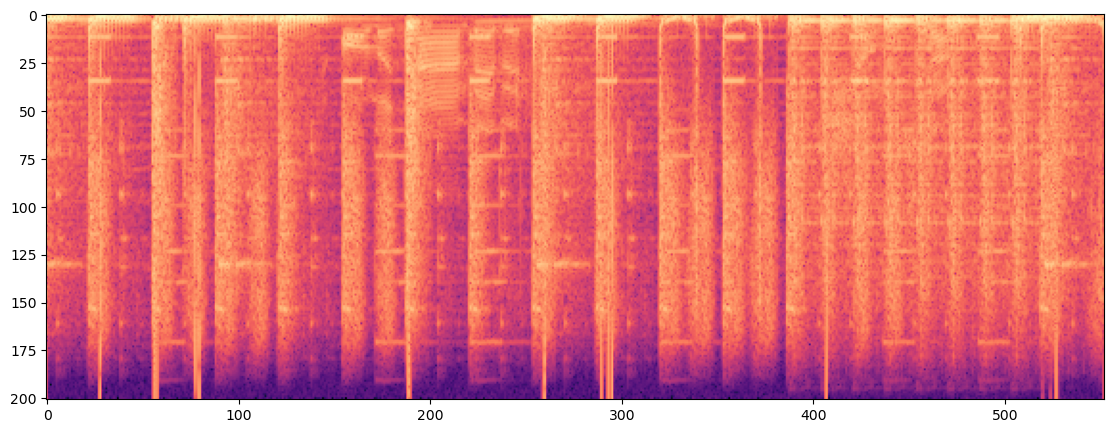

In [14]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[ 0.8140,  0.7851,  0.7409,  ...,  0.0149, -0.0179,  0.0418]])



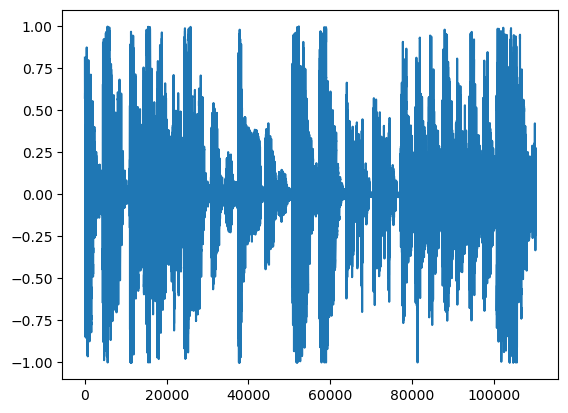

In [15]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

In [16]:
IPython.display.Audio(waveform,rate=samplerate)

## Clasificación **(Prueba de modelos)**

In [22]:
dataset = MusicDataset()
train_dataset, val_dataset, test_dataset = stratify_split(
    dataset, 
    dataset.classes,
    transforms_waveform
)

In [23]:
n_input = 110250
num_epochs = 100

### MLP

In [24]:
hyperparameter_configs_MLP = [
    {
        "learning_rate": 0.001,
        "batch_size": 32,
        "nodes": 64
    },
    {
        "learning_rate": 0.0005,
        "batch_size": 32,
        "nodes": 128
    },
    {
        "learning_rate": 0.001,
        "batch_size": 16,
        "nodes": 32
    }
]

#### by Waveform

In [25]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
del dataset, train_dataset, val_dataset, test_dataset
gc.collect()  # Importante para liberar memoria RAM

dataset = MusicDataset()
train_dataset, val_dataset, test_dataset = stratify_split(
    dataset, 
    dataset.classes,
    transforms_waveform
)

by = "waveform"
model_name = "MLP"

train_model(model_name, num_epochs, device, hyperparameter_configs_MLP, dataset, train_dataset, val_dataset, n_input, by)

KeyError: 'hidden_layers'

#### by Spectogram

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
del dataset, train_dataset, val_dataset, test_dataset, trainloader, valloader, testloader
gc.collect()  # Importante para liberar memoria RAM

dataset = MusicDataset()
train_dataset, val_dataset, test_dataset = stratify_split(
    dataset, 
    dataset.classes,
    transforms_waveform
)

by = "spectogram"
model_name = "MLP"

train_model(model_name, num_epochs, device, hyperparameter_configs_MLP, dataset, train_dataset, val_dataset, n_input, by)

### MLP2

In [23]:
# Define una lista de configuraciones de hiperparámetros sin 'dense_layers'
hyperparameter_configs_MLP2 = [
    {
        "learning_rate": 0.001,
        "batch_size": 32,
        "nodes": 64,
        "hidden_layers": 3
    },
    {
        "learning_rate": 0.0005,
        "batch_size": 32,
        "nodes": 128,
        "hidden_layers": 4
    },
    {
        "learning_rate": 0.001,
        "batch_size": 16,
        "nodes": 32,
        "hidden_layers": 2
    }
]

#### by Waveform

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
del dataset, train_dataset, val_dataset, test_dataset, trainloader, valloader, testloader
gc.collect()  # Importante para liberar memoria RAM

dataset = MusicDataset()
train_dataset, val_dataset, test_dataset = stratify_split(
    dataset, 
    dataset.classes,
    transforms_waveform
)

by = "waveform"
model_name = "MLP2"

train_model(model_name, num_epochs, device, hyperparameter_configs_MLP2, dataset, train_dataset, val_dataset, n_input, by)

#### by Spectogram

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
del dataset, train_dataset, val_dataset, test_dataset, trainloader, valloader, testloader
gc.collect()  # Importante para liberar memoria RAM

dataset = MusicDataset()
train_dataset, val_dataset, test_dataset = stratify_split(
    dataset, 
    dataset.classes,
    transforms_waveform
)

by = "spectogram"
model_name = "MLP2"

train_model(model_name, num_epochs, device, hyperparameter_configs_MLP2, dataset, train_dataset, val_dataset, n_input, by)

### CEL

In [ ]:
# Define a list of hyperparameter configurations
hyperparameter_configs_CEL = [
    {
        "learning_rate": 0.001,
        "batch_size": 32,
        "nodes": 64,
        "hidden_layers": 3,
        "dropout_prob": 0.3,
        "dense_layers": 2
    },
    {
        "learning_rate": 0.0005,
        "batch_size": 32,
        "nodes": 128,
        "hidden_layers": 4,
        "dropout_prob": 0.4,
        "dense_layers": 2
    },
    {
        "learning_rate": 0.001,
        "batch_size": 16,
        "nodes": 32,
        "hidden_layers": 2,
        "dropout_prob": 0.2,
        "dense_layers": 3
    }
]

#### by Waveform

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
del dataset, train_dataset, val_dataset, test_dataset, trainloader, valloader, testloader
gc.collect()  # Importante para liberar memoria RAM

dataset = MusicDataset()
train_dataset, val_dataset, test_dataset = stratify_split(
    dataset, 
    dataset.classes,
    transforms_waveform
)

by = "waveform"
model_name = "CEL"

train_model(model_name, num_epochs, device, hyperparameter_configs_CEL, dataset, train_dataset, val_dataset, n_input, by)

#### by Spectogram

In [ ]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
del dataset, train_dataset, val_dataset, test_dataset, trainloader, valloader, testloader
gc.collect()  # Importante para liberar memoria RAM

dataset = MusicDataset()
train_dataset, val_dataset, test_dataset = stratify_split(
    dataset, 
    dataset.classes,
    transforms_waveform
)

by = "spectogram"
model_name = "CEL"

train_model(model_name, num_epochs, device, hyperparameter_configs_CEL, dataset, train_dataset, val_dataset, n_input, by)